In [1]:
import scanpy as sc

### Reading AnnData object with inVAE embedding 

In [2]:
adata_invae = sc.read_h5ad("/lustre/scratch126/cellgen/team292/ha10/data/Spatial_Lung/adata_train_inVAE_processed.h5ad")

In [6]:
adata_invae

AnnData object with n_obs × n_vars = 46325 × 4000
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Celltypes_colors', 'Donor_colors', 'Loc_true_colors', 'PoolDon_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_FinVAE', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

#### Subset AT1 object

In [24]:
AT1 = adata_invae[adata_invae.obs['Celltypes'] == 'AT1 ']

In [8]:
AT1 = AT1.raw.to_adata()

In [9]:
sc.pp.filter_genes(AT1, min_cells=3)

### Run HotSpot analysis based on inVAE embedding

In [10]:
import hotspot

In [11]:
from scipy.sparse import csc_matrix
AT1.X = csc_matrix(AT1.X)

In [14]:
hs = hotspot.Hotspot(
    AT1,
    model='danb',
    latent_obsm_key="X_FinVAE"
)


In [15]:
hs.create_knn_graph(
    weighted_graph=True, n_neighbors=20,
)

In [66]:
import pickle
# Saving HS object
with open('./hs_objects/AT1_hs_object.obj', 'wb') as f:
    pickle.dump(hs, f)

### Downstream analysis of HS

In [2]:
import pickle
with open('./hs_objects/AT1_hs_object.obj', 'rb') as f:
    hs = pickle.load(f)

In [3]:
AT1 = hs.adata

In [4]:

hs_results = hs.compute_autocorrelations(jobs=1)

hs_results.head(15)

# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(1000).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=1)


100%|██████████| 21731/21731 [00:14<00:00, 1541.80it/s]


Computing pair-wise local correlation on 1000 features...


100%|██████████| 499500/499500 [01:07<00:00, 7407.89it/s]


In [5]:
modules = hs.create_modules(
    min_gene_threshold=50, core_only=True, fdr_threshold=0.05
)

modules.value_counts()


Module
-1    156
 2    149
 5    143
 1    125
 3    112
 7    102
 4     96
 6     61
 8     56
Name: count, dtype: int64

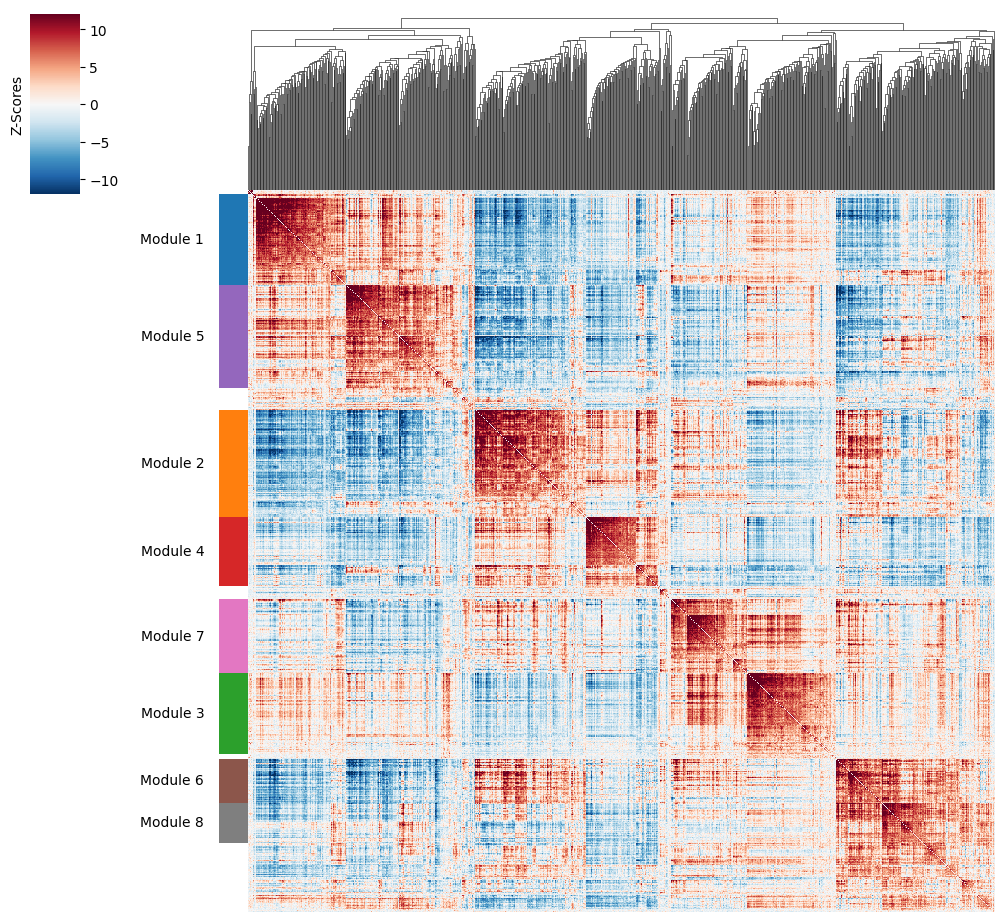

In [6]:
hs.plot_local_correlations(vmin=-12, vmax=12)

In [7]:
module_scores = hs.calculate_module_scores()

Computing scores for 8 modules...


100%|██████████| 8/8 [00:01<00:00,  4.19it/s]


In [8]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    AT1.obs[key] = module_scores[c]
    module_cols.append(key)

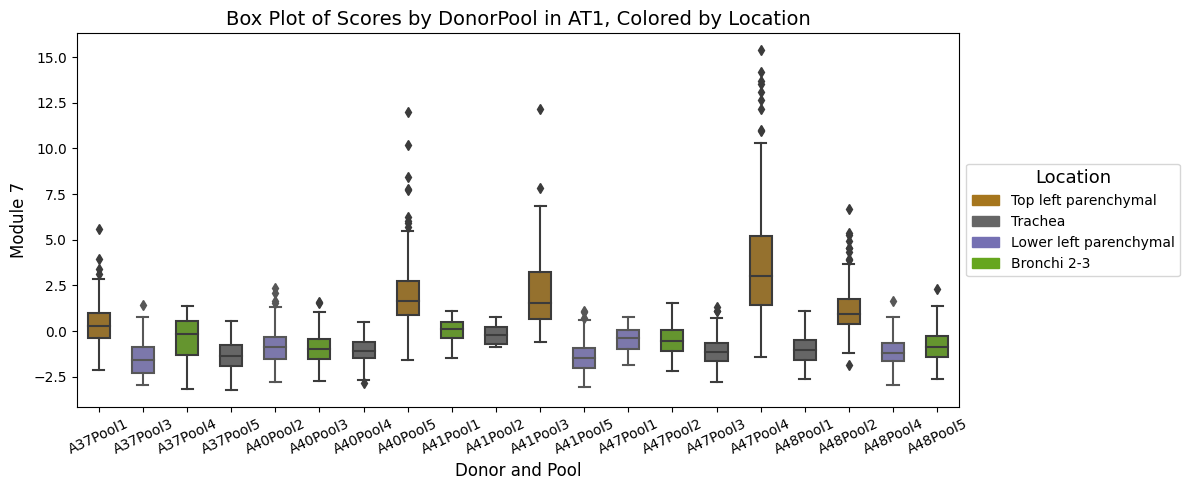

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

colors_dict = {
    'b_Bronchi.2.3':'#7570b3ff', 'c_Bronchi.4':'#66a61eff', 'd_LowLeftPar':'#a6761dff', 'e_TopLeftPar':'#666666ff', 'a_Trachea': '#1b9e77ff'
}

# New names for Loc_true values
new_names = ['Top left parenchymal','Trachea', 'Lower left parenchymal','Bronchi 2-3', 'Bronchi 4']  # Replace with actual new names

# Map the original locations to new names
original_locations = AT1.obs['Loc_true'].unique()
location_name_map = dict(zip(original_locations, new_names))

# Initialize the plot
plt.figure(figsize=(12, 5))

# Plot each location separately
for loc in original_locations:
    subset = AT1.obs[AT1.obs['Loc_true'] == loc]
    sns.boxplot(
        x='DonorPool', y='Module 7', data=subset, 
        color=colors_dict[loc], width=0.5
    )

# Customize axis labels
plt.xlabel('Donor and Pool', fontsize=12)
plt.ylabel('Module 7', fontsize=12)
plt.title('Box Plot of Scores by DonorPool in AT1, Colored by Location', fontsize=14)

# Create a custom legend with new names for Loc_true
legend_handles = [mpatches.Patch(color=colors_dict[loc], label=location_name_map[loc]) for loc in original_locations]
plt.legend(handles=legend_handles, title='Location', title_fontsize='13', fontsize='10', loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

In [11]:
AT1

AnnData object with n_obs × n_vars = 3502 × 21731
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_counts', 'Module 1', 'Module 2', 'Module 3', 'Module 4', 'Module 5', 'Module 6', 'Module 7', 'Module 8', 'Module 9'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'Celltypes_colors', 'Donor_colors', 'Loc_true_colors', 'PoolDon_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_FinVAE', 'X_umap', 'X_scANVI', 'X_scVI'
    obsp: 'connectivities', 'distances'

In [17]:
import scanpy as sc

In [15]:
sc.settings.set_figure_params(figsize=(4,3))

In [12]:
AT1.uns['Loc_true_colors'] = ['#7570b3', '#66a61e', '#a6761d', '#666666']

/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


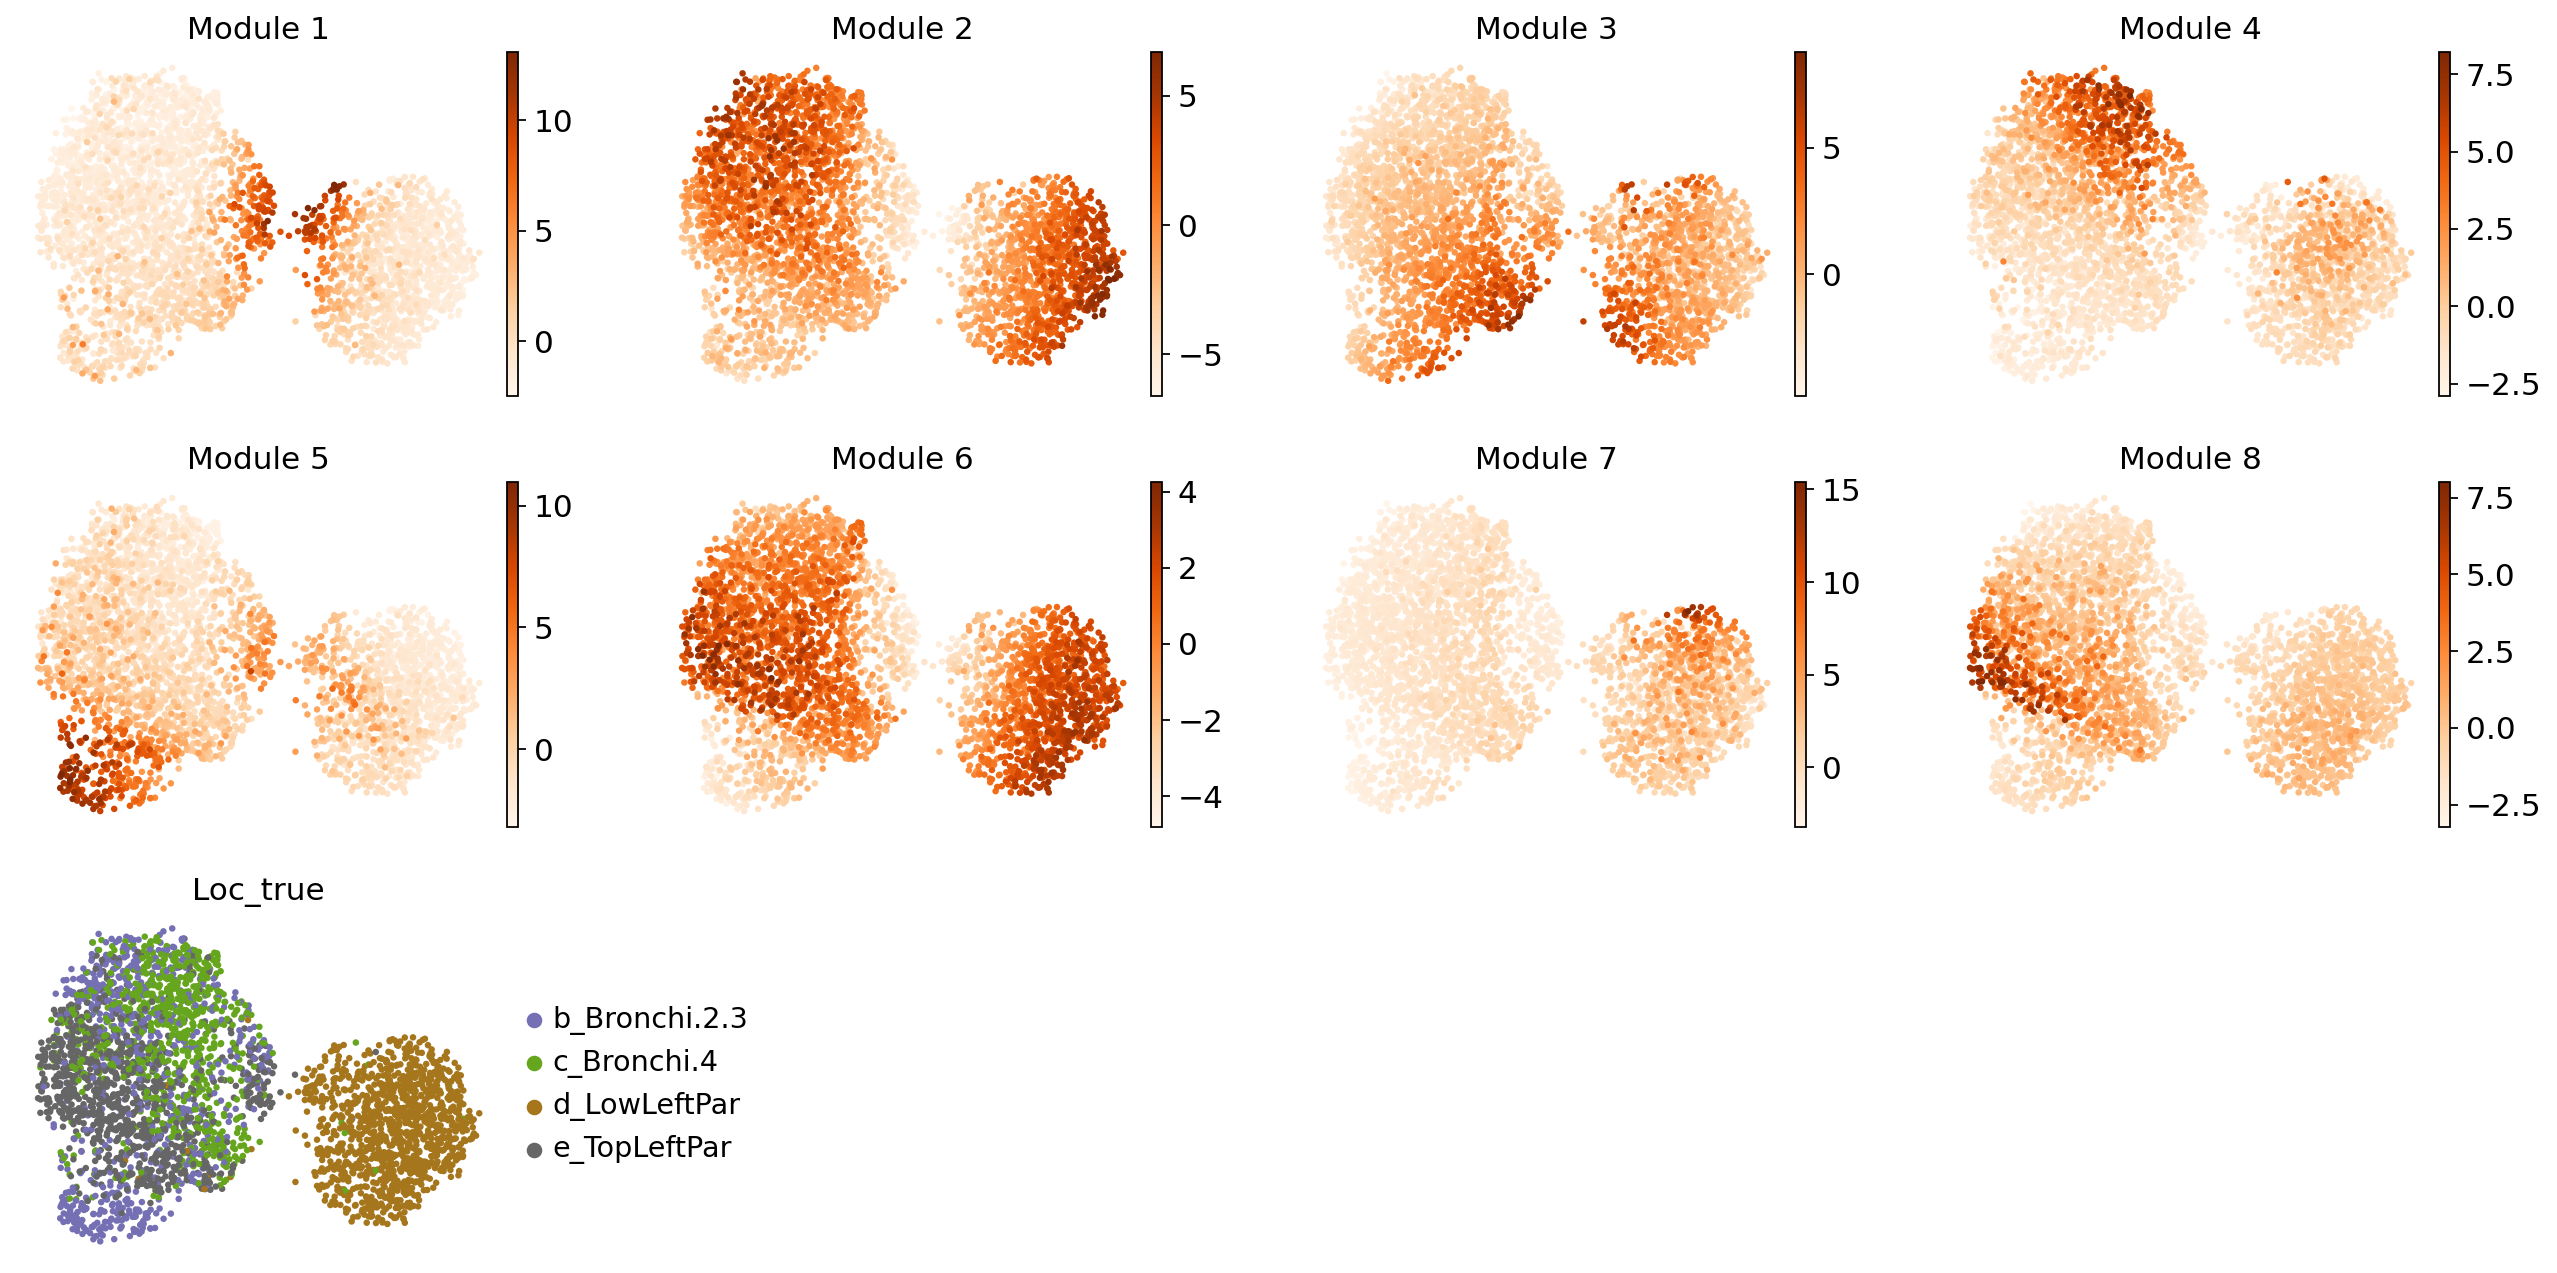

In [16]:
sc.pl.umap(AT1, color=module_cols + ['Loc_true'], frameon=False,ncols=4,cmap='Oranges')

In [26]:
module = 7

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

C          Z           Pval            FDR  Module
Gene                                                                 
AGER        0.223509  54.003422   0.000000e+00   0.000000e+00     7.0
PDE4D       0.270867  52.820543   0.000000e+00   0.000000e+00     7.0
S100A6      0.201804  50.296301   0.000000e+00   0.000000e+00     7.0
CSGALNACT1  0.175134  44.198110   0.000000e+00   0.000000e+00     7.0
GPC5        0.207820  37.181949  6.680174e-303  3.722227e-300     7.0
PTPRD       0.188097  36.746015  6.730658e-296  3.567413e-293     7.0
KRT7        0.129816  33.624261  3.708342e-248  1.413789e-245     7.0
CLDN18      0.149509  32.296809  3.877546e-229  1.337507e-226     7.0
CASC15      0.151608  31.559277  6.688113e-219  2.106368e-216     7.0
NEDD4L      0.124423  31.333817  8.082385e-216  2.473779e-213     7.0

In [28]:
import numpy as np
import pandas as pd
def groupby_obs_var(adata, obs_name, var_names):
    # Extract observation data
    obs_data = adata.obs[obs_name]

    
    # Convert to DataFrame
    var_df = adata[:,var_names].to_df()
    
    # Concatenate observation data with variable data
    combined_df = pd.concat([obs_data, var_df], axis=1)
    
    # Group by the observation name and aggregate gene lists
    grouped_df = combined_df.groupby(obs_name).agg(lambda x: np.mean(x))
    
    return grouped_df

# Example usage
# Assuming 'adata' is your AnnData object, 'Loc_true' is your observation name, and var_names is a list of gene names
# adata = ad.read_h5ad('your_anndata_file.h5ad')


In [29]:
obs_name = 'Loc_true'
var_names = list(results.sort_values('Z', ascending=False).index)  # Replace with your gene names
grouped_df = groupby_obs_var(AT1, obs_name, var_names)

obs_data = AT1.obs[obs_name]

use_genes = list(grouped_df.columns[grouped_df.idxmax() == "d_LowLeftPar"])


In [39]:
results.loc[use_genes].to_csv("figures/Updated_AT1_plots/Dataframe_AT1_HS_module_7_top_genes.csv")

In [2]:
import pandas as pd
results = pd.read_csv("./figures/Updated_folder/Updated_AT1_plots/Dataframe_AT1_HS_module_7_top_genes.csv")

In [4]:
use_genes = list(results.Gene)

In [31]:
# sc.pl.dotplot(AT1,groupby='Loc_true', var_names=list(results.sort_values('Z', ascending=False).index),standard_scale='var',figsize=(12,3),save='_AT1_HS_cluster_8_top_genes.pdf')

/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


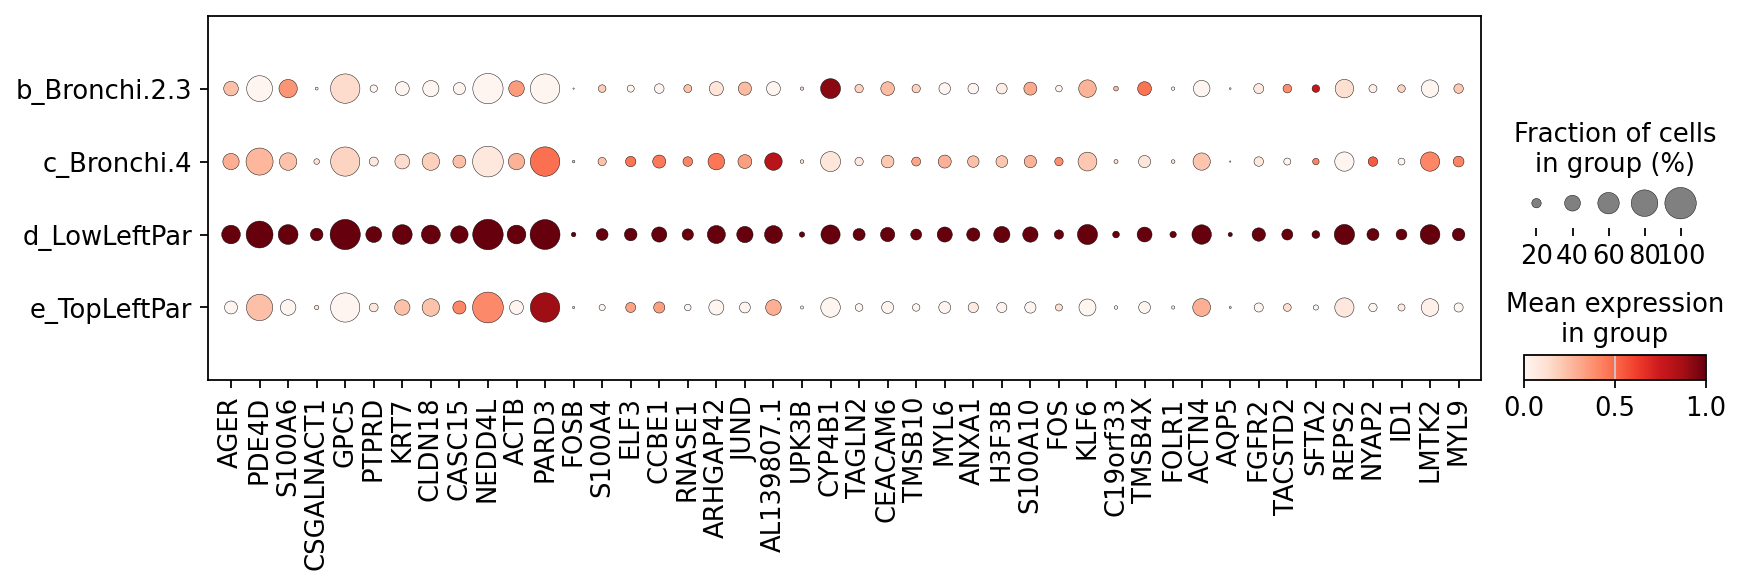

In [34]:
sc.pl.dotplot(AT1,groupby='Loc_true', var_names=use_genes[:44],standard_scale='var',figsize=(12,3),save='_updated_AT1_HS_cluster_7_top_genes.pdf')

In [5]:
import gseapy
import matplotlib.pyplot as plt

In [130]:
enr = gseapy.enrichr(gene_list=use_genes, # or "./tests/data/gene_list.txt",
                 gene_sets=['WikiPathways_2024_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [222]:
data = enr.res2d[:100]

In [224]:
highlight_terms = [
    "TGF Beta Signaling Pathway WP366", 
    "VEGFA VEGFR2 Signaling WP3888", 
    "PDGF Pathway WP2526", 
    "EGF EGFR Signaling WP437"
]

In [227]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [235]:
highlighted_data = data[data.Term.isin(highlight_terms)]

In [236]:
highlighted_data

Gene_set                              Term Overlap  \
0   WikiPathways_2024_Human  TGF Beta Signaling Pathway WP366   8/132   
12  WikiPathways_2024_Human     VEGFA VEGFR2 Signaling WP3888   9/430   
20  WikiPathways_2024_Human               PDGF Pathway WP2526    3/40   
22  WikiPathways_2024_Human          EGF EGFR Signaling WP437   5/159   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   3.007923e-07          0.000078            0                     0   
12  2.832379e-04          0.005389            0                     0   
20  1.017669e-03          0.012600            0                     0   
22  1.169220e-03          0.013217            0                     0   

    Odds Ratio  Combined Score  \
0    14.021269      210.555238   
12    4.627078       37.799636   
20   16.777027      115.597755   
22    6.820600       46.048721   

                                                Genes  log10_adjusted_pvalue  
0           JUN;KLF6;JUND;ZFYVE9;NEDD4L;FOSB;FOS;ATF3               4.106760  
12  NFKBIA;EGR1;JUN;ANXA1;TMSB4X;HSPB1;EZR;TMSB10;...               2.268481  
20                                     NFKBIA;JUN;FOS               1.899639  
22                            JUN;JUND;REPS2;FOSB;FOS               1.878858

/tmp/ipykernel_209/2017570551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log10_adjusted_pvalue'] = -np.log10(data['Adjusted P-value'])


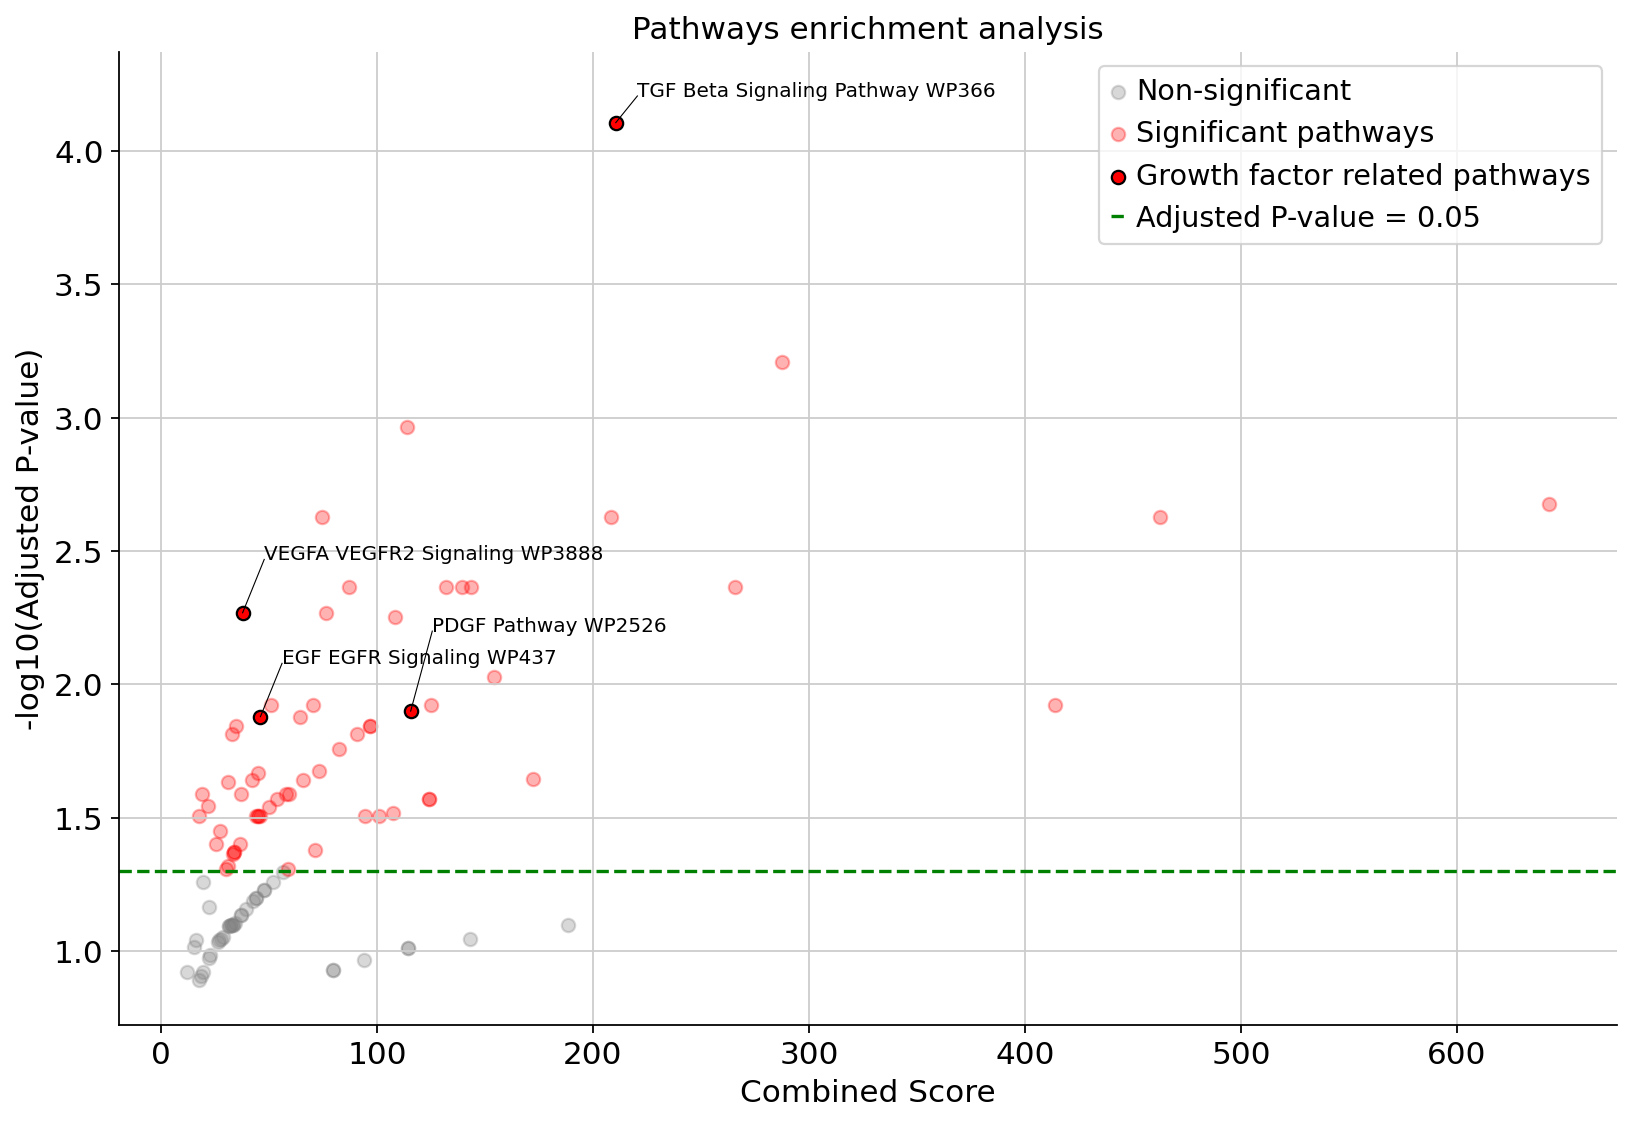

In [254]:
# Manually calculate -log10(Adjusted P-value) for sorting
data['log10_adjusted_pvalue'] = -np.log10(data['Adjusted P-value'])

# Sort the data by -log10(Adjusted P-value) to find the top 10
top_10_data = data.nlargest(10, 'log10_adjusted_pvalue')

# Create the plot with updated highlighting
plt.figure(figsize=(12,8))

# Plot non-significant points (Adjusted P-value >= 0.05) as grey with low opacity
non_significant = data[data['Adjusted P-value'] >= 0.05]
plt.scatter(non_significant['Combined Score'], 
            non_significant['log10_adjusted_pvalue'],
            color='grey', alpha=0.3, marker='o', label='Non-significant')

# Plot significant points that are not highlighted (Adjusted P-value < 0.05) as red with low opacity
significant = data[(data['Adjusted P-value'] < 0.05) & (~data['Term'].isin(highlight_terms))]
plt.scatter(significant['Combined Score'], 
            significant['log10_adjusted_pvalue'],
            color='red', alpha=0.3, marker='o', label='Significant pathways')

# Highlighted significant points with high opacity
highlighted_significant = data[(data['Adjusted P-value'] < 0.05) & (data['Term'].isin(highlight_terms))]
plt.scatter(highlighted_significant['Combined Score'], 
            highlighted_significant['log10_adjusted_pvalue'],
            color='red', alpha=1.0, marker='o', label='Growth factor related pathways', edgecolors='black')

# Add a line where Adjusted P-value = 0.05
plt.axhline(-np.log10(0.05), color='green', linestyle='--', label='Adjusted P-value = 0.05')

# Plot top 10 points and add text labels with connecting lines
for i, row in highlighted_data.iterrows():
#     plt.scatter(row['Combined Score'], row['log10_adjusted_pvalue'], color='blue', s=100)
    if i == 0:
        plt.text(row['Combined Score'] + 10, row['log10_adjusted_pvalue']+0.1, row['Term'], fontsize=9)
        plt.plot([row['Combined Score'], row['Combined Score'] + 10], 
             [row['log10_adjusted_pvalue'], row['log10_adjusted_pvalue']+0.1], 
             color='black', linestyle='-', linewidth=0.5)
    elif i ==20:
        plt.text(row['Combined Score'] + 10, row['log10_adjusted_pvalue']+0.3, row['Term'], fontsize=9)
        plt.plot([row['Combined Score'], row['Combined Score'] + 10], 
             [row['log10_adjusted_pvalue'], row['log10_adjusted_pvalue']+0.3], 
             color='black', linestyle='-', linewidth=0.5)
    else:
        plt.text(row['Combined Score'] + 10, row['log10_adjusted_pvalue']+0.2, row['Term'], fontsize=9)
        plt.plot([row['Combined Score'], row['Combined Score'] + 10], 
             [row['log10_adjusted_pvalue'], row['log10_adjusted_pvalue']+0.2], 
             color='black', linestyle='-', linewidth=0.5)
    

# Labeling the axes
plt.xlabel('Combined Score')
plt.ylabel('-log10(Adjusted P-value)')
plt.title('Pathways enrichment analysis')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.savefig('figures/AT1_plots/WP_enrichment_analysis_AT1.pdf', bbox_inches='tight')
plt.show()


In [142]:
Growth_factor = ['JUN','JUND','FOSB','FOS','KLF6','ZFYVE9','NEDD4L','ATF3', # TGF Beta
 'REPS2', #EGF EGFR
 'NFKBIA','EGR1','ANXA1','TMSB4X','HSPB1','EZR','TMSB10','ACTG1' # VEGFA VEGFR2
]

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from statannotations.Annotator import Annotator
import seaborn as sns
import scipy.stats as sci_stats

def label_plot_for_subcats(ax,gene):
    plt.title(gene, y=1.06)
    ax.set_ylabel("expression (log+1)")
    # ax.set_xlabel("cell type", labelpad=20)

def get_log_ax(label_plot_for_subcats,orient="v"):
    if orient == "v":
        figsize = (6, 6)
        set_scale = "set_yscale"
    else:
        figsize = (6, 6)
        set_scale = "set_xscale"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_alpha(1)
    getattr(ax, set_scale)("log")
    return ax    

def plot_box_with_pvalue(data,x,y,gene,desired_order,colors_dict,save=None):

    plotting_parameters = {
        'data':    data,
        'x':       x,
        'y':       y,
        # 'palette': subcat_palette[1:]
    }
    # Calculate p-values for each pair of consecutive time points
    p_values = []
    
    # Convert 'new_celltype' column to categorical with desired order
#     data[x] = pd.Categorical(data[x], categories=desired_order, ordered=True)

    # Sort the DataFrame based on the categorical 'new_celltype' column
    data = data.sort_values(by=x)
    
    time_points = data[x].unique()
    print(time_points)
    for i in range(len(time_points) - 1):
        sample1 = data[data[x] == time_points[i]][y]
        sample2 = data[data[x] == time_points[i+1]][y]
        _, p = ttest_ind(sample1, sample2, equal_var=False)
        p_values.append(p)

    # Prepare pairs for annotator
    pairs = [(time_points[i], time_points[i+1]) for i in range(len(time_points) - 1)]

    # Transform each p-value to "p=" in scientific notation
    formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in p_values]

    with sns.plotting_context('notebook', font_scale = 1.4):
        # Create new plot
        ax = get_log_ax(gene)
        
        # Plot with seaborn
        sns.boxplot(**plotting_parameters,palette=colors_dict)
        
        # Remove top and right border of the axis
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        sns.despine()
        
        
        # Add annotations
        annotator = Annotator(ax, pairs, **plotting_parameters)
        annotator.set_custom_annotations(formatted_pvalues)
        annotator.annotate()

        # Label and show
        label_plot_for_subcats(ax,gene)
    if save:
        plt.savefig(save)

    plt.show()

In [103]:
sc.tl.score_genes(AT1,Growth_factor,score_name='GF_score')

/home/jovyan/my-conda-envs/general/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


In [104]:
AT1.obs

Celltypes Celltypes_master_high  \
HCA_A_LNG9387709-AAACCCAGTCTGATAC      AT1              Epithelia   
HCA_A_LNG9387709-AAAGGGCGTTGGTAGG      AT1              Epithelia   
HCA_A_LNG9387709-AAAGTCCCAAGCGATG      AT1              Epithelia   
HCA_A_LNG9387709-AACAACCTCCACGTAA      AT1              Epithelia   
HCA_A_LNG9387709-AACCCAATCATGGTAC      AT1              Epithelia   
...                                     ...                   ...   
HCA_A_LNG9387718-TTGGGTACAGTGTGCC      AT1              Epithelia   
HCA_A_LNG9387718-TTGTTCAAGGCCACCT      AT1              Epithelia   
HCA_A_LNG9387718-TTGTTTGCACGGGTAA      AT1              Epithelia   
HCA_A_LNG9387718-TTTACGTAGGTTCTAC      AT1              Epithelia   
HCA_A_LNG9387718-TTTCCTCGTACCGCGT      AT1              Epithelia   

                                  Celltypes_master_higher  \
HCA_A_LNG9387709-AAACCCAGTCTGATAC               Epithelia   
HCA_A_LNG9387709-AAAGGGCGTTGGTAGG               Epithelia   
HCA_A_LNG9387709-AAAGTCCCAAGCGATG               Epithelia   
HCA_A_LNG9387709-AACAACCTCCACGTAA               Epithelia   
HCA_A_LNG9387709-AACCCAATCATGGTAC               Epithelia   
...                                                   ...   
HCA_A_LNG9387718-TTGGGTACAGTGTGCC               Epithelia   
HCA_A_LNG9387718-TTGTTCAAGGCCACCT               Epithelia   
HCA_A_LNG9387718-TTGTTTGCACGGGTAA               Epithelia   
HCA_A_LNG9387718-TTTACGTAGGTTCTAC               Epithelia   
HCA_A_LNG9387718-TTTCCTCGTACCGCGT               Epithelia   

                                  Celltypes_master_higher_immune  \
HCA_A_LNG9387709-AAACCCAGTCTGATAC                            AT1   
HCA_A_LNG9387709-AAAGGGCGTTGGTAGG                            AT1   
HCA_A_LNG9387709-AAAGTCCCAAGCGATG                            AT1   
HCA_A_LNG9387709-AACAACCTCCACGTAA                            AT1   
HCA_A_LNG9387709-AACCCAATCATGGTAC                            AT1   
...                                                          ...   
HCA_A_LNG9387718-TTGGGTACAGTGTGCC                            AT1   
HCA_A_LNG9387718-TTGTTCAAGGCCACCT                            AT1   
HCA_A_LNG9387718-TTGTTTGCACGGGTAA                            AT1   
HCA_A_LNG9387718-TTTACGTAGGTTCTAC                            AT1   
HCA_A_LNG9387718-TTTCCTCGTACCGCGT                            AT1   

                                        Loc_true Material Donor Donor_ID_2  \
HCA_A_LNG9387709-AAACCCAGTCTGATAC   d_LowLeftPar   nuclei   A37        nan   
HCA_A_LNG9387709-AAAGGGCGTTGGTAGG   d_LowLeftPar   nuclei   A37        nan   
HCA_A_LNG9387709-AAAGTCCCAAGCGATG   d_LowLeftPar   nuclei   A37        nan   
HCA_A_LNG9387709-AACAACCTCCACGTAA   d_LowLeftPar   nuclei   A37        nan   
HCA_A_LNG9387709-AACCCAATCATGGTAC   e_TopLeftPar   nuclei   A48        nan   
...                                          ...      ...   ...        ...   
HCA_A_LNG9387718-TTGGGTACAGTGTGCC  b_Bronchi.2.3   nuclei   A41        nan   
HCA_A_LNG9387718-TTGTTCAAGGCCACCT   e_TopLeftPar   nuclei   A37        nan   
HCA_A_LNG9387718-TTGTTTGCACGGGTAA   d_LowLeftPar   nuclei   A40        nan   
HCA_A_LNG9387718-TTTACGTAGGTTCTAC    c_Bronchi.4   nuclei   A48        nan   
HCA_A_LNG9387718-TTTCCTCGTACCGCGT   e_TopLeftPar   nuclei   A37        nan   

                                  Gender            Sample                ID  \
HCA_A_LNG9387709-AAACCCAGTCTGATAC    nan  HCA_A_LNG9387709  HCA_A_LNG9387709   
HCA_A_LNG9387709-AAAGGGCGTTGGTAGG    nan  HCA_A_LNG9387709  HCA_A_LNG9387709   
HCA_A_LNG9387709-AAAGTCCCAAGCGATG    nan  HCA_A_LNG9387709  HCA_A_LNG9387709   
HCA_A_LNG9387709-AACAACCTCCACGTAA    nan  HCA_A_LNG9387709  HCA_A_LNG9387709   
HCA_A_LNG9387709-AACCCAATCATGGTAC    nan  HCA_A_LNG9387709  HCA_A_LNG9387709   
...                                  ...               ...               ...   
HCA_A_LNG9387718-TTGGGTACAGTGTGCC    nan  HCA_A_LNG9387718  HCA_A_LNG9387718   
HCA_A_LNG9387718-TTGTTCAAGGCCACCT    nan  HCA_A_LNG9387718  HCA_A_LNG9387718  

In [101]:
colors_dict = {
    'b_Bronchi.2.3':'#7570b3ff', 'c_Bronchi.4':'#66a61eff', 'd_LowLeftPar':'#a6761dff', 'e_TopLeftPar':'#666666ff'
}

In [106]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

['b_Bronchi.2.3', 'c_Bronchi.4', 'd_LowLeftPar', 'e_TopLeftPar']
Categories (4, object): ['b_Bronchi.2.3', 'c_Bronchi.4', 'd_LowLeftPar', 'e_TopLeftPar']
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

b_Bronchi.2.3 vs. c_Bronchi.4: p=3.85e-01
c_Bronchi.4 vs. d_LowLeftPar: p=1.16e-18
d_LowLeftPar vs. e_TopLeftPar: p=3.15e-19


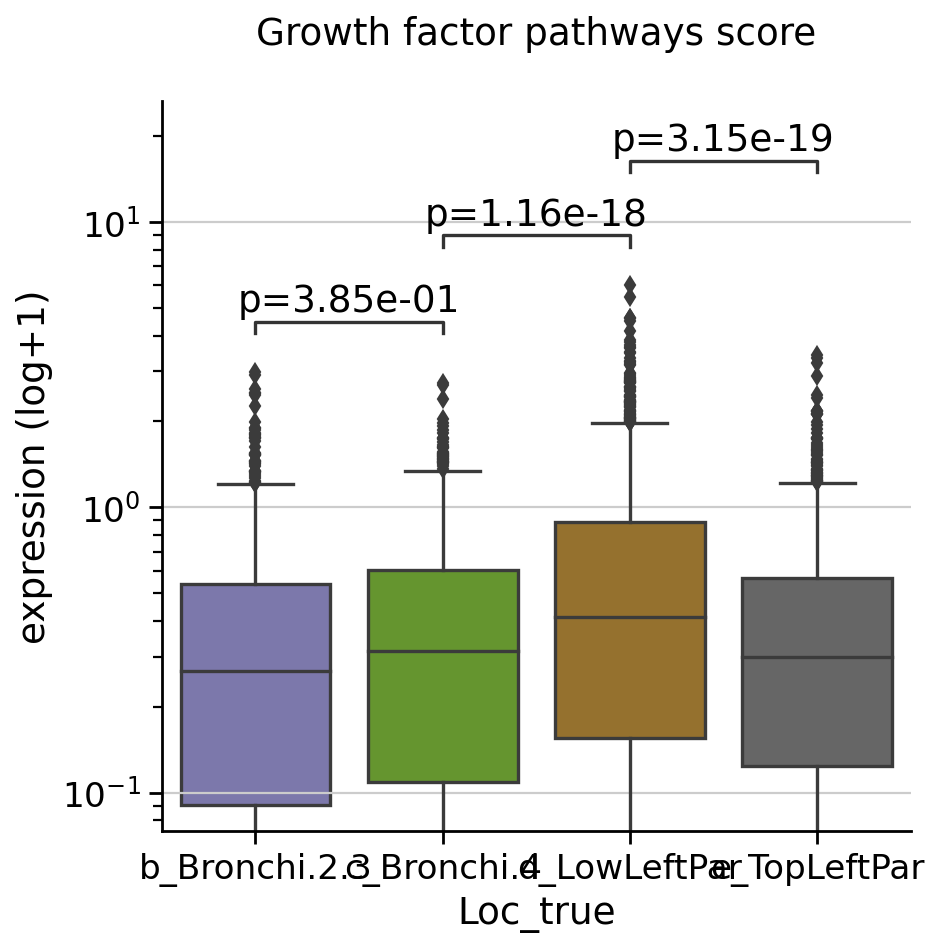

In [113]:
plot_box_with_pvalue(AT1.obs,'Loc_true','GF_score', 'Growth factor pathways score',['b_Bronchi.2.3','c_Bronchi.4','d_LowLeftPar','e_TopLeftPar'],colors_dict,save='figures/AT1_plots/AT1_GF_score_box_plot.pdf')